# ToO Secondary Targeting

Parse a set of target-of-opportunity observations created using the script

`/path/to/timedomain/bin/td_from_program TOO > too_tgt.out`

In [1]:
import os
from astropy.io import ascii, fits
from astropy.table import join, hstack, vstack, unique, Table
from desispec.spectra import stack as specstack
from desispec.io import read_spectra, write_spectra

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=16)
mpl.rc('axes', titlesize='small')

## Load ToO Target ASCII DB

Load the ToO secondary targets from an ASCII file.
Then plot the data.

In [3]:
too_targets = ascii.read('too_tgt.out', delimiter='|',
                        names=['PROGRAM', 'TARGET_RA', 'TARGET_DEC', 'TARGETID', 'TILEID', 'DATE', 'PETAL'])
too_targets

PROGRAM,TARGET_RA,TARGET_DEC,TARGETID,TILEID,DATE,PETAL
str3,float64,float64,int64,int64,int64,int64
ToO,216.688787,-1.861117,43977414082035733,225,20210503,0
ToO,221.1424,-0.8466,43977438316724380,252,20210419,8
ToO,220.8908,-0.758,43977438312530123,252,20210419,8
ToO,221.0202,-0.7057,43977438316724318,252,20210419,8
ToO,219.1058,-1.3357,43977426203574529,253,20210502,1
ToO,218.8378,-1.5061,43977420159582429,253,20210502,1
ToO,218.9367,-0.7497,43977438278975605,253,20210502,2
ToO,219.4608,-0.1939,43977450366959770,253,20210502,4
ToO,220.217,0.0324,43977456419340540,253,20210502,6


In [4]:
def plot_radec(table):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    table : astropy.table.Table
        Data table with secondary target info.
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation.
    """
    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    
    # Loop through unique classes.
    class_names = np.unique(table['PROGRAM'])
    for class_name in class_names:
        select = table['PROGRAM'] == class_name
        
        # Convert RA, Dec to radians.
        # Rotate the RA so that the plot goes 360->0 left to right.
        _ra = np.radians(180. - table[select]['TARGET_RA'])
        _dec = np.radians(table[select]['TARGET_DEC'])
        ax.scatter(_ra, _dec, alpha=0.5, s=5, label=class_name)

    # Clean up the plot and return the Figure object.
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    
    ax.legend(fontsize=8, loc='lower right')
    fig.tight_layout()

    return fig;

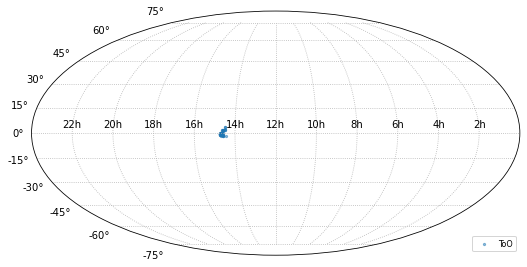

In [5]:
fig = plot_radec(too_targets)

## Extract Object Redshifts

For each object in the table, extract the redshift.

In [6]:
tile_date_petal = []

for too_target in too_targets:
    tdp = [too_target[_] for _ in ['TILEID', 'DATE', 'PETAL']]
    if tdp in tile_date_petal:
        continue
    tile_date_petal.append(tdp)

In [ ]:
redux = 'daily'

toospec = None

n = 0

for i, (tile, date, petal) in enumerate(tile_date_petal):
    select = (too_targets['TILEID']==tile) & (too_targets['DATE']==date) & (too_targets['PETAL']==petal)
    n += np.sum(select)
    targetids = too_targets[select]['TARGETID']
    
    folder = '{}/{}/tiles/{}/{}'.format(os.environ['DESI_SPECTRO_REDUX'], redux, tile, date)
    cdfile = '{}/coadd-{}-{}-{}.fits'.format(folder, petal, tile, date)
    zbfile = '{}/zbest-{}-{}-{}.fits'.format(folder, petal, tile, date)
    
    if os.path.exists(zbfile) and os.path.exists(cdfile):
        spectra = read_spectra(cdfile)
        
        # Select matching target IDs from the ToO list and read out ToO spectra.
        sselect = np.in1d(spectra.fibermap['TARGETID'], targetids)
        spectra = spectra[sselect]
        if not hasattr(spectra, 'scores_comments'):
            spectra.scores_comments = None
        
        # Select matching target IDs from the ToO list and access the redshift fit.
        zbest = fits.open(zbfile)['ZBEST'].data
        zselect = np.in1d(zbest['TARGETID'], targetids)
        zbest = zbest[zselect]
        
        # Append spectra to a larger list of spectra, stored in memory.
        # Note that an EXPID is required in the update step below, but the coadded spectra
        # have a FIRST_EXPID and a LAST_EXPID. So copy one of these as a hack.
        spectra.fibermap['EXPID'] = spectra.fibermap['LAST_EXPID']
        spectra.extra_catalog = zbest
        
        if toospec is None:
            toospec = spectra
        else:
            toospec = specstack([toospec, spectra])
        
        if (i+1) % 10 == 0:
            print('{} out of {}; ({} {})'.format(i+1, len(tile_date_petal), n, toospec.num_spectra()))
            
if not hasattr(toospec, 'scores_comments'):
    toospec.scores_comments = None

INFO:spectra.py:253:read_spectra: iotime 0.489 sec to read coadd-0-225-20210503.fits at 2021-05-24T12:06:09.850130
INFO:spectra.py:253:read_spectra: iotime 0.608 sec to read coadd-8-252-20210419.fits at 2021-05-24T12:06:10.926533
INFO:spectra.py:253:read_spectra: iotime 0.540 sec to read coadd-1-253-20210502.fits at 2021-05-24T12:06:11.976629
INFO:spectra.py:253:read_spectra: iotime 0.489 sec to read coadd-2-253-20210502.fits at 2021-05-24T12:06:12.962793
INFO:spectra.py:253:read_spectra: iotime 0.758 sec to read coadd-4-253-20210502.fits at 2021-05-24T12:06:14.245166
INFO:spectra.py:253:read_spectra: iotime 0.576 sec to read coadd-6-253-20210502.fits at 2021-05-24T12:06:15.366025
INFO:spectra.py:253:read_spectra: iotime 0.491 sec to read coadd-8-253-20210502.fits at 2021-05-24T12:06:16.360638
INFO:spectra.py:253:read_spectra: iotime 0.546 sec to read coadd-0-261-20210430.fits at 2021-05-24T12:06:17.498423
INFO:spectra.py:253:read_spectra: iotime 0.520 sec to read coadd-4-261-20210430.

In [ ]:
toospec.num_spectra()

### Output Redrock Spectral Types

In [ ]:
types_, counts_ = np.unique(toospec.extra_catalog['SPECTYPE'], return_counts=True)
for t, c in zip(types_, counts_):
    print('{:10s} : {:10d} ({:.1f}%)'.format(t, c, 100*c/len(toospec.extra_catalog)))

## Write Output

### FITS Format

This format is needed to preserve the redrock template coefficients in the output, should they be needed for spectral matching and plotting later.

**WARNING**: the output file will *always* be clobbered so proceed with caution!

In [ ]:
write_spectra('too_redshifts.fits', toospec)

## Plot Spectra

Probably should pull in `plot_spectra` here but it's easy to write some code too.

### Grab Legacy Survey Cutouts

Some code to access legacy survey cutouts.

In [ ]:
import requests

def get_cutout(targetid, ra, dec, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    """
    img_name = '{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        if verbose:
            print('Accessing {}'.format(img_name))
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&%22/pix=0.25&layer=dr8&size=180'.format(ra, dec)
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
    
    return img_name

#### Spectrum Plot Options

Pull in a basic Gaussian smoothing filter and some code for plotting the same emission and absorption features used in Prospect.

In [ ]:
from scipy.ndimage import gaussian_filter1d

mpl.rc('figure', max_open_warning = 0)

In [ ]:
# Emission and absorption lines from Prospect tables.
emi_lines = ascii.read('emission_lines.txt', comment='#', names=['name','longname','lambda','vacuum','major'])
abs_lines = ascii.read('absorption_lines.txt', comment='#', names=['name','longname','lambda','vacuum','major'])

emi_lines_major = emi_lines[emi_lines['major']=='True']
abs_lines_major = abs_lines[abs_lines['major']=='True']

In [ ]:
for i in range(toospec.num_spectra()):
    
    fig, axes = plt.subplots(1,2, figsize=(16,5), gridspec_kw={'width_ratios':[3,1.1]},
                             tight_layout=True)
    
    # Plot the spectra.
    ax = axes[0]
    
    fmin, fmax = 1e99, -1e99
    for band in 'brz':
        smoothed = gaussian_filter1d(toospec.flux[band][i], 5)
        fmin = np.minimum(fmin, np.min(smoothed))
        fmax = np.maximum(fmax, np.max(smoothed))
        ax.plot(toospec.wave[band], smoothed)
        
    zbest = toospec.extra_catalog[i]
    z = zbest['Z']
    dchi2 = zbest['DELTACHI2']
    zwarn = zbest['ZWARN']
    sptype = zbest['SPECTYPE']
    print(dchi2, zwarn)
    
    for eline in emi_lines:
        wl = eline['lambda']*(1 + z)
        if wl > 3600 and wl < 9800:
            ax.axvline(wl, ls='--', color='k', alpha=0.3)
            ax.text(wl+20, fmin, eline['name'], fontsize=8, rotation=90, alpha=0.3)

    for aline in abs_lines:
        wl = aline['lambda']*(1 + z)
        if wl > 3600 and wl < 9800:
            ax.axvline(wl, ls='--', color='r', alpha=0.3)
            ax.text(wl+20, 0.95*fmax, aline['name'], color='r', fontsize=8, rotation=90, alpha=0.3)

    ax.set(xlabel=r'$\lambda_{\mathrm{obs}}$ [$\AA$]',
           xlim=(3500,9900),
           ylabel=r'flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
           title=r'{}; $z={:.3f}$ ($\Delta\chi^2={:.5g}$; ZWARN=0x{:x}; SPECTYPE={:s})'.format(toospec.fibermap[i]['TARGETID'], z, dchi2, zwarn, sptype.decode('utf-8')),
          )
    
    # Plot the image cutout.
    ax = axes[1]
    
    obj = toospec.fibermap[i]
    img_file = get_cutout(obj['TARGETID'], obj['TARGET_RA'], obj['TARGET_DEC'])
    img = mpl.image.imread(img_file)

    ax.imshow(img)

    x1, x2, x3, x4 = [90, 90], [70, 80], [90, 90], [100,110]
    y1, y2, y3, y4 = [70, 80], [90, 90], [100,110], [90,90]
    ax.plot(x1, y1, x2, y2, x3, y3, x4, y4, color='r', linewidth=2, alpha=0.7)
    ax.text(5,15, '{:3s} = {}\n{:3s} = {}'.format('RA', obj['TARGET_RA'], 'Dec', obj['TARGET_DEC']), color='yellow', fontsize=9)
    ax.set(aspect='equal')
    ax.axis('off')
    
    fig.savefig('spec_cutout_{}.png'.format(obj['TARGETID']), dpi=100)